In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Function to import and preprocess a CSV file
def import_df(filepath, column):
    df = pd.read_csv(filepath, sep=';', low_memory=False)
    df[column] = df[column].astype(str)  # Ensure all entries are strings
    df[column] = df[column].str.pad(width=20, side='right', fillchar='0') 
    df[column] = pd.to_datetime(df[column], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')

    # Remove the last row for the first CSV and calculate intervals
    if column == 'date':
        df = df.iloc[:-1]
        df = df[df['tagLabel'] == 'Start trial']
        date_interval = df.groupby('trialid')['date'].transform(lambda x: pd.Interval(x.min(), x.max())).copy()
        df.loc[:, 'date_diff'] = (df.groupby('trialid')['date'].transform(lambda x: (x.max() - x.min()).total_seconds()))
        df['date_interval'] = date_interval
        df = df.drop_duplicates(subset='trialid', keep='first')
        df = df[df['date_diff'] <= 15] # only keep trials <15sec, for all processing (both reaction time and accuracy)

    return df

def process_csv_pair(csv1, csv2, participant_id):
    df_start_trial = import_df(csv1, 'date')
    df_other = import_df(csv2, 'date_end')

    df_other['participant_id'] = participant_id

    is_in_interval, corresponding_fieldOfView, corresponding_answer_correct = [], [], []

    # Check if each date in df_other is in any of the intervals in df_start_trial
    for idx, date in df_other['date_end'].items():
        is_in_any_interval = False
        for _, interval_row in df_start_trial.iterrows():
            if date in interval_row['date_interval']:
                is_in_any_interval = True
                corresponding_fieldOfView.append(interval_row['fieldOfView'])
                corresponding_answer_correct.append(df_other.loc[idx, 'answer_correct'])
                break
        is_in_interval.append(is_in_any_interval)

        if not is_in_any_interval:
            corresponding_fieldOfView.append(None)
            corresponding_answer_correct.append(None)
        
    df_other['is_in_interval'] = is_in_interval
    df_other['corresponding_fieldOfView'] = corresponding_fieldOfView
    df_other['corresponding_answer_correct'] = [1 if ans else 0 for ans in corresponding_answer_correct]

    df_other = df_other[df_other['corresponding_fieldOfView'].isin([20, 45])]
    df_start_trial = df_start_trial[df_start_trial['fieldOfView'].isin([20, 45])]
    
    return df_start_trial, df_other

# Loop to extract and combine DataFrames for all participants
def combine_data(prefixes, path1, path2):
    combined_df_other = pd.DataFrame()
    combined_df_start_trial = pd.DataFrame()
    
    for prefix in prefixes:
        if prefix == 'P8':
            # Handle P8's two separate parts
            csv1_part1 = f"{path1}\\{prefix}-PostEEG_TrackerData_part1.csv"
            csv1_part2 = f"{path1}\\{prefix}-PostEEG_TrackerData_part2.csv"
            csv2 = f"{path2}\\post_eeg_button_tags_{prefix}.csv"
            
            df_start_part1, df_other_part1 = process_csv_pair(csv1_part1, csv2, prefix)
            df_start_part2, df_other_part2 = process_csv_pair(csv1_part2, csv2, prefix)
            df_other_combined = pd.concat([df_other_part1, df_other_part2], ignore_index=True)
            
            # Combine start_trial DataFrames for P8
            df_start_trial = pd.concat([df_start_part1, df_start_part2], ignore_index=True)
        else:
            csv1 = f"{path1}\\{prefix}-PostEEG_TrackerData.csv"
            csv2 = f"{path2}\\post_eeg_button_tags_{prefix}.csv"
            df_start_trial, df_other = process_csv_pair(csv1, csv2, prefix)
            df_other_combined = df_other  # No need to combine for other participants

        combined_df_other = pd.concat([combined_df_other, df_other_combined], ignore_index=True)
        combined_df_start_trial = pd.concat([combined_df_start_trial, df_start_trial], ignore_index=True)
        
    return combined_df_start_trial, combined_df_other


def plot_accuracy(df):
    unique_participants = df['participant_id'].unique()
    num_participants = len(unique_participants)

    ncols = 3
    nrows = (num_participants + ncols - 1) // ncols  # This will create enough rows for all participants
    colors = sns.color_palette("Set2", 2) 

    participant_map = {'P0': 'P001', 'P1': 'P002', 'P2': 'P003', 'P3': 'P004', 'P4': 'P005', 'P5': 'P006',
        'P6': 'P007', 'P7': 'P008', 'P8': 'P009'}

    plt.figure(figsize=(ncols * 4, nrows * 4), dpi=300)
    plt.suptitle('Success Rate by Field of View for Each Participant', fontsize=16)

    for i, participant in enumerate(unique_participants):
        participant_data = df[df['participant_id'] == participant].copy()

        # Calculate success rate and convert to percentage, filtering out any unwanted FoV
        success_rate = (participant_data.groupby('corresponding_fieldOfView')['corresponding_answer_correct'].mean() * 100)
        success_rate_df = success_rate.reset_index()
        success_rate_df.columns = ['Field of View', 'Success Rate (%)']

        # Create a subplot for each participant
        plt.subplot(nrows, ncols, i + 1)
        sns.barplot(x='Field of View', y='Success Rate (%)', hue='Field of View', data=success_rate_df, palette=[colors[0], colors[1]])
        plt.title(f'{participant_map.get(participant, participant)}')
        plt.xlabel('Field of View (FoV)' if i >= (nrows - 1) * ncols else '') # only on bottom row
        plt.ylabel('Success Rate (%)' if i % ncols == 0 else '') # only on left column

        plt.xticks([0, 1], ["20°", "45°"])
        plt.ylim(0, 100)  # Set y-axis limits for better visibility
        plt.legend([], [], frameon=False)

    plt.tight_layout()
    plt.show()

def plot_combined_accuracy(df, ax):
    # Calculate overall success rate for each Field of View across all participants
    overall_success_rate = df.groupby('corresponding_fieldOfView')['corresponding_answer_correct'].mean() * 100
    overall_success_rate_df = overall_success_rate.reset_index()
    overall_success_rate_df.columns = ['Field of View', 'Success Rate (%)']

    barplot = sns.barplot(x='Field of View', y='Success Rate (%)', hue='Field of View', data=overall_success_rate_df, palette="Set2", dodge=False, ax=ax, legend=False)

    # Annotate bars with the mean values
    for index, row in overall_success_rate_df.iterrows():
        barplot.text(row.name, row['Success Rate (%)'] + 5, f"{row['Success Rate (%)']:.1f}%", color='black', ha="center")

    ax.set_title('Overall Success Rate by Field Of View')
    ax.set_xlabel('Field of View (FoV)')
    ax.set_ylabel('Success Rate (%)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['20°', '45°'])
    ax.set_ylim([0,100])

    # Statistical test: compare Field of View groups
    group_20 = df[df['corresponding_fieldOfView'] == 20]['corresponding_answer_correct']
    group_45 = df[df['corresponding_fieldOfView'] == 45]['corresponding_answer_correct']
    
    t_stat, p_val = stats.ttest_ind(group_20, group_45, equal_var=False, nan_policy='omit')

    significance_level = ""
    if p_val < 0.001:
        significance_level = '***'
    elif p_val < 0.01:
        significance_level = '**'
    elif p_val < 0.05:
        significance_level = '*'

    print(f'Success Rate comparison:\nT-statistic: {t_stat}')
    print(f'P-value: {p_val}\n')

def plot_boxplot_and_stats(df, ax):
    group_20 = df[df['fieldOfView'] == 20]['date_diff']
    group_45 = df[df['fieldOfView'] == 45]['date_diff']

    t_stat, p_val = stats.ttest_ind(group_20, group_45, equal_var=False, nan_policy='omit')

    sns.boxplot(x='fieldOfView', y='date_diff', data=df, color='white', linewidth=1.2, ax=ax)
    ax.set_title('Trial time (reaction time) by Field Of View')
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Field of View (FoV)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['20°', '45°'])

    # Add jitter for individual data points
    fovs = [20, 45]
    colors = sns.color_palette('Set2', len(fovs)) 
    for i, fov in enumerate(fovs):
        y = df.loc[df['fieldOfView'] == fov, 'date_diff']
        x = np.random.normal(i, 0.04, size=len(y))  # add jitter to the x-coordinate
        ax.plot(x, y, '.', color=colors[i], alpha=0.6)

    # Annotate means and medians
    mean_20 = group_20.mean()
    mean_45 = group_45.mean()
    ymax = max(mean_20, mean_45) + 1

    ax.plot([0, 1], [group_20.median(), group_45.median()], color='black')

    # Significance annotation
    if p_val < 0.001:
        ax.text(0.5, ymax, '***', ha='center', weight='bold')
    elif p_val < 0.01:
        ax.text(0.5, ymax, '**', ha='center', weight='bold')
    elif p_val < 0.05:
        ax.text(0.5, ymax, '*', ha='center', weight='bold')
    
    print(f'Reaction time comparison:\nT-statistic: {t_stat}')
    print(f'P-value: {p_val}')
    print(f'Means: {mean_20:.2f} (20°), {mean_45:.2f} (45°)')

    
def plot_combined_accuracy_and_boxplot(df1, df2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)  # Create two subplots side by side
    
    # Call first plot function, passing ax1
    plot_combined_accuracy(df1, ax=ax1)
    
    # Call second plot function, passing ax2
    plot_boxplot_and_stats(df2, ax=ax2)
    
    plt.tight_layout()  # Adjust layout so plots don't overlap
    plt.show()

In [2]:
prefixes = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
path1 = 'F:\\PM_Polyretina\\Data\\Post_2023_Control_Center_Data'
path2 = 'F:\\PM_Polyretina\\Data\\Post_2023_Button_tags'

df_start_trial_combined, df_other_combined = combine_data(prefixes, path1, path2)

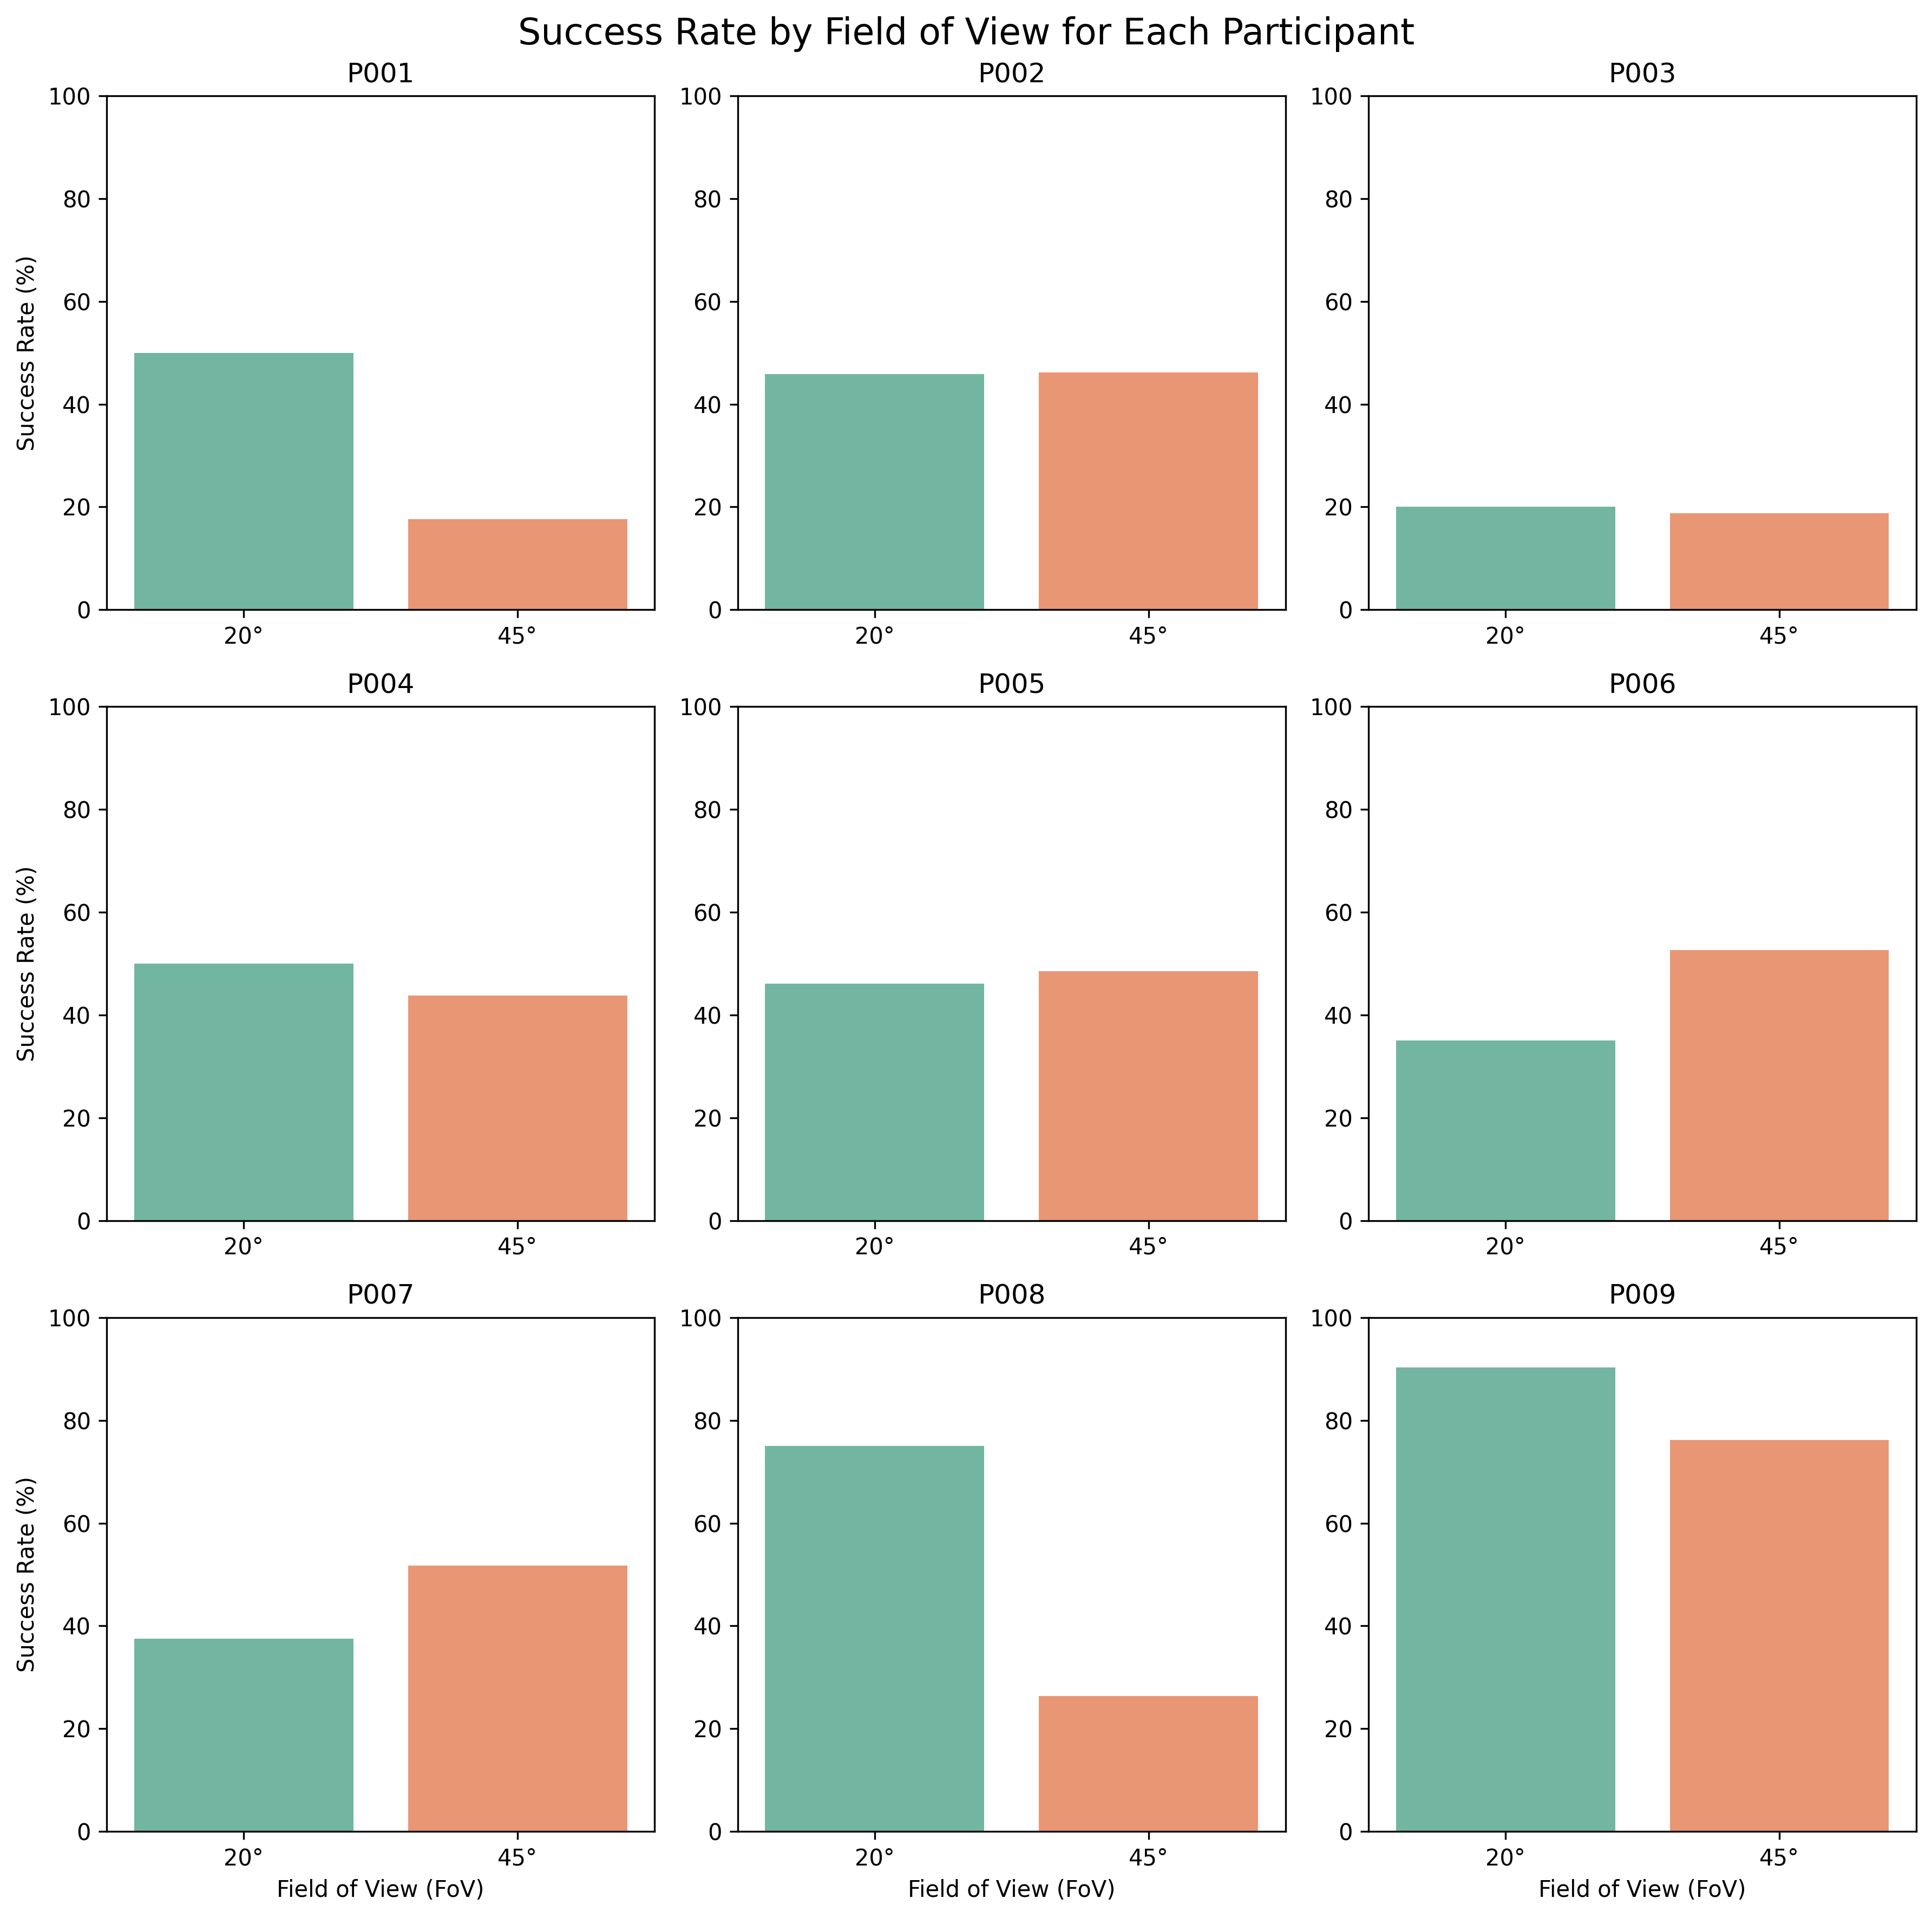

Success Rate comparison:
T-statistic: 0.5932179854814413
P-value: 0.5534431564090448

Reaction time comparison:
T-statistic: 2.8248724759950163
P-value: 0.004863599669070964
Means: 9.89 (20°), 9.13 (45°)


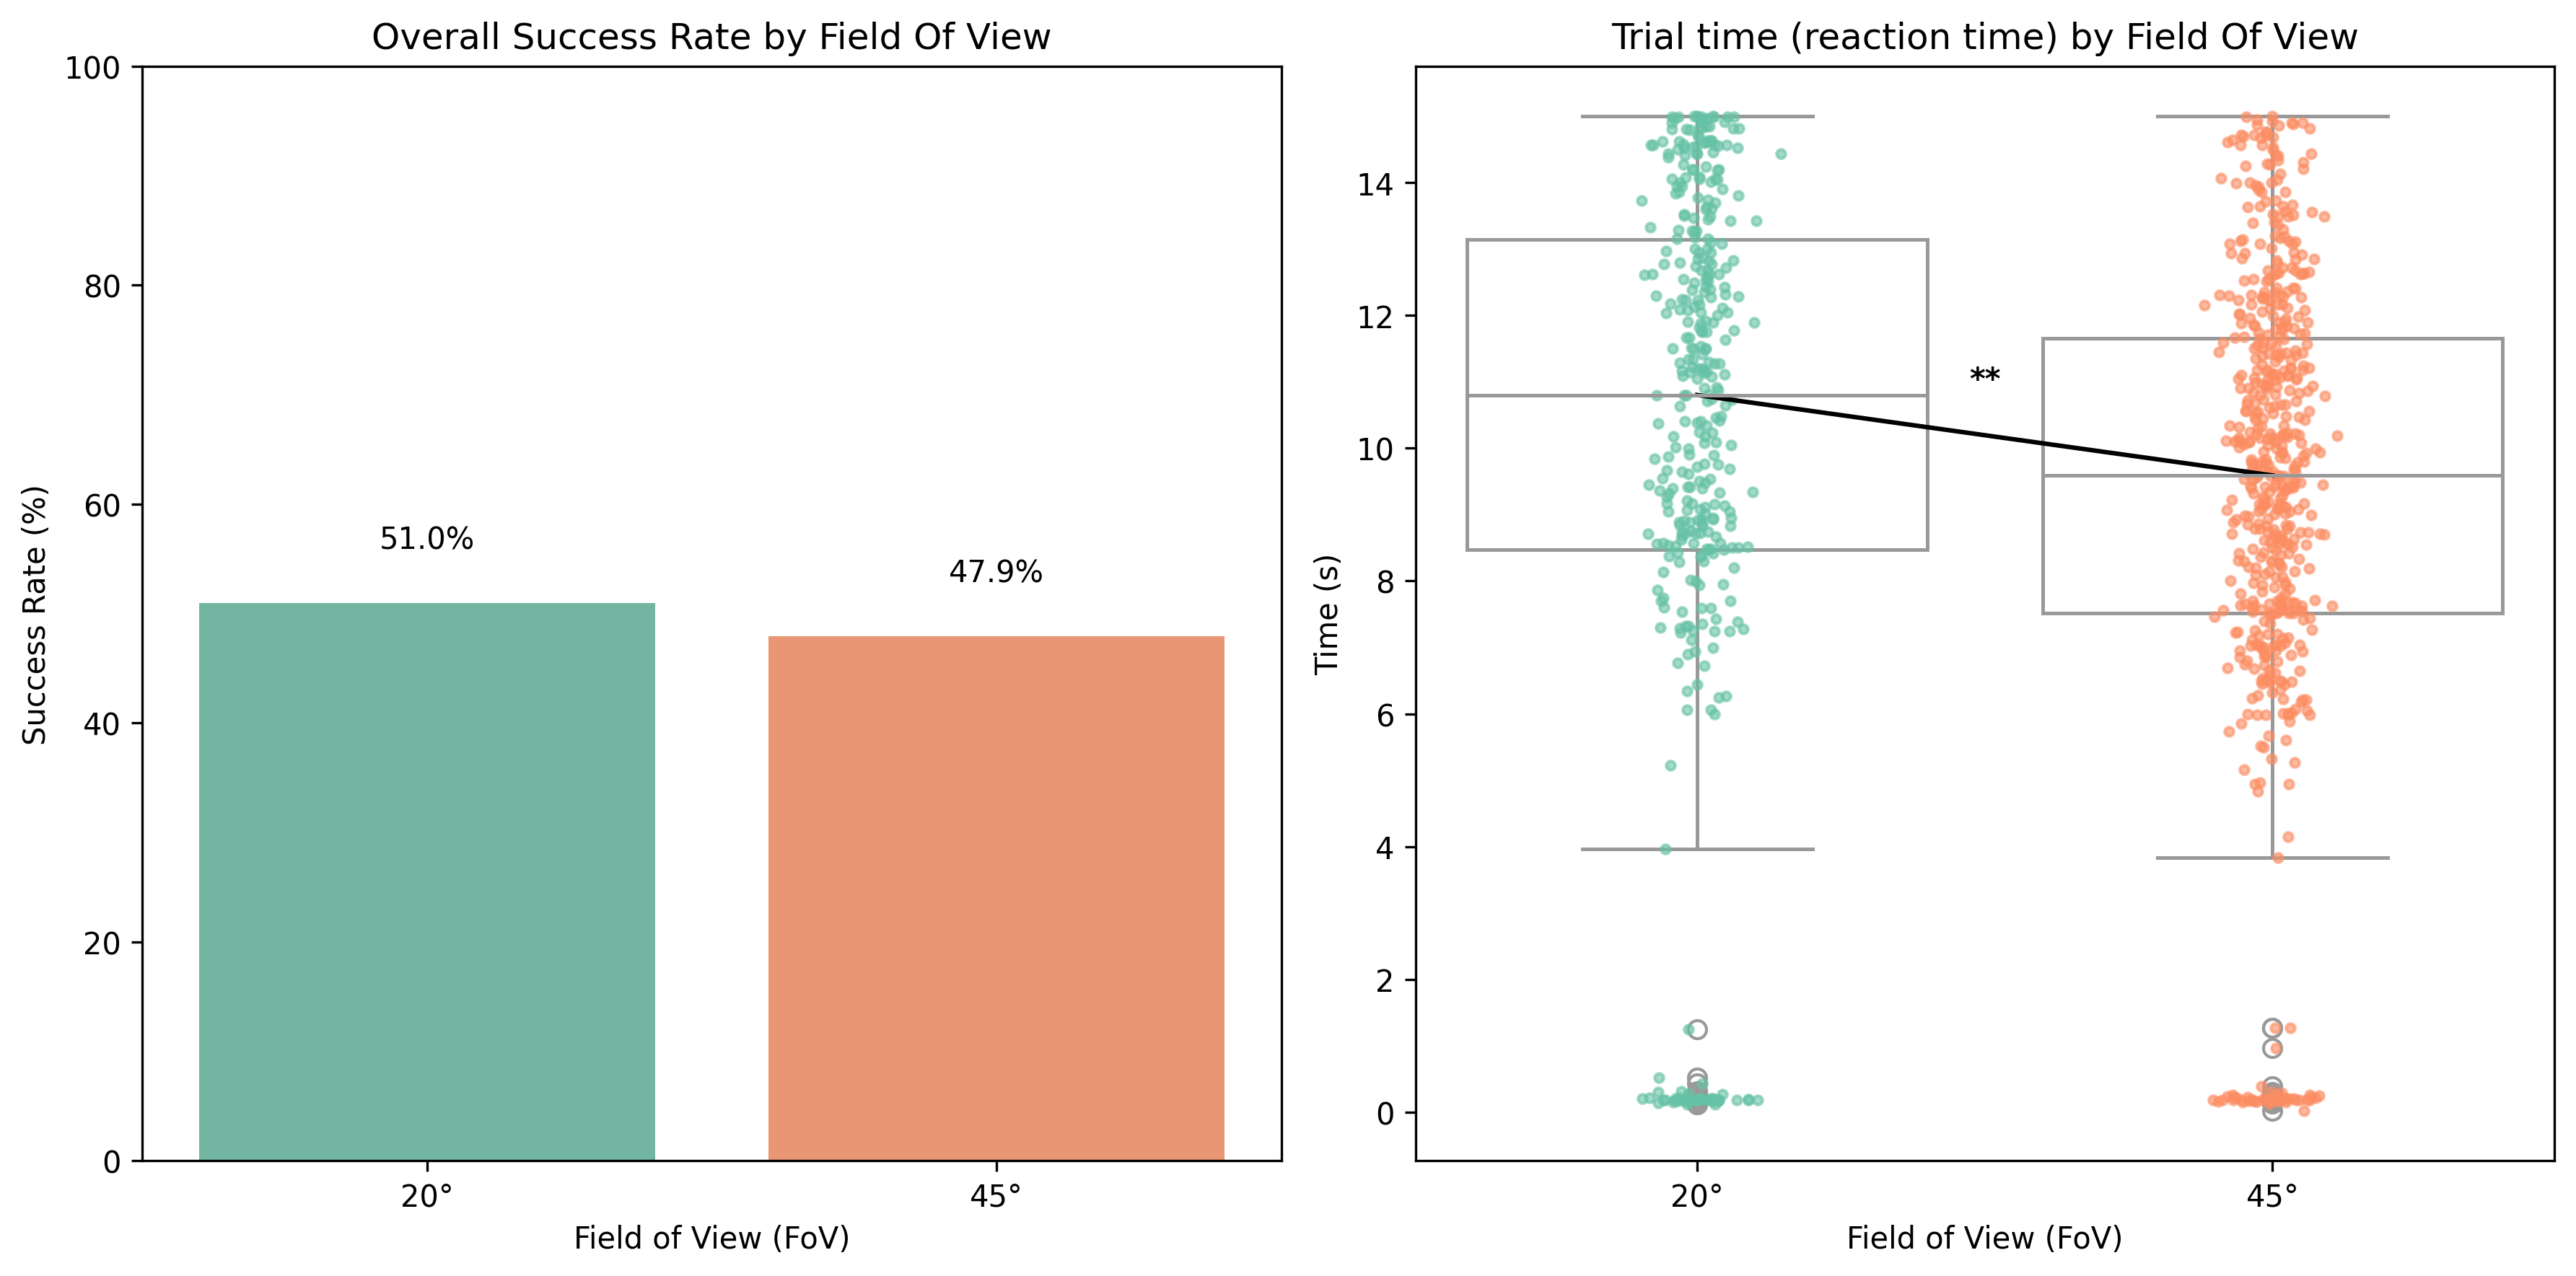

In [5]:
plot_accuracy(df_other_combined)
plot_combined_accuracy_and_boxplot(df_other_combined, df_start_trial_combined)

corresponding_fieldOfView
0.0      0.000000
20.0    35.714286
45.0    20.833333
Name: corresponding_answer_correct, dtype: float64


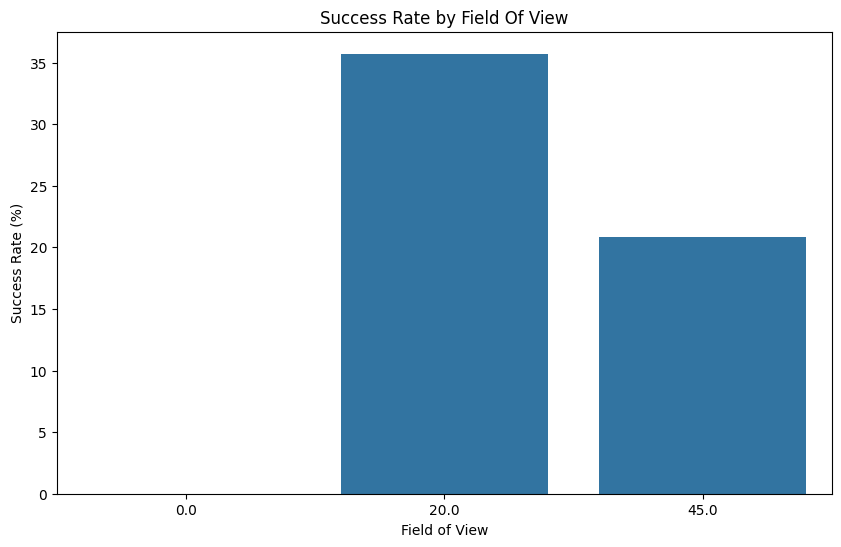

T-statistic: nan
P-value: nan
Cohen's d: 0.3260253318483131
corresponding_fieldOfView
20.0    44.444444
45.0    45.454545
Name: corresponding_answer_correct, dtype: float64


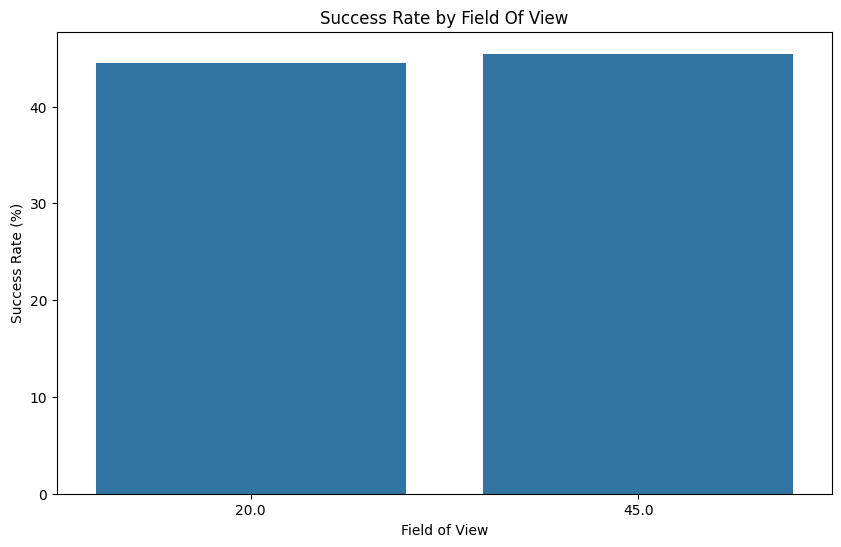

T-statistic: -0.08303479670198122
P-value: 0.9340714553283762
Cohen's d: -0.02001135294296949
corresponding_fieldOfView
0.0      0.000000
20.0    35.714286
45.0    24.000000
Name: corresponding_answer_correct, dtype: float64


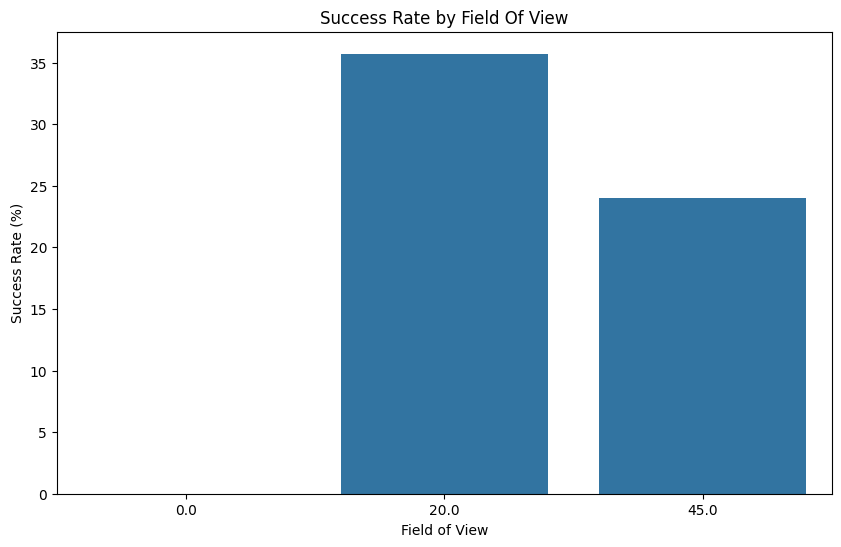

T-statistic: 0.9171521064371467
P-value: 0.36337986216355067
Cohen's d: 0.2523656736793175
corresponding_fieldOfView
20.0    50.000000
45.0    40.740741
Name: corresponding_answer_correct, dtype: float64


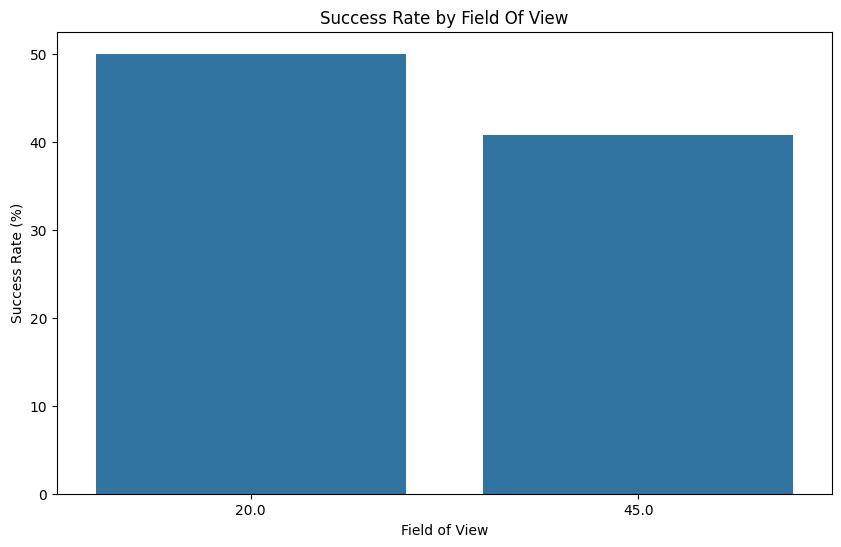

T-statistic: 0.6011194039582537
P-value: 0.5509163427360018
Cohen's d: 0.1829148096122199
corresponding_fieldOfView
0.0      0.000
20.0    40.625
45.0    50.000
Name: corresponding_answer_correct, dtype: float64


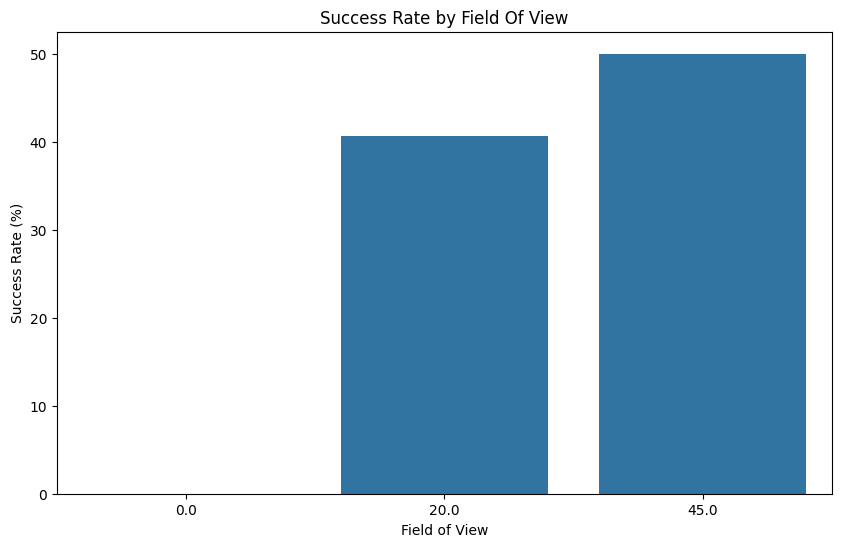

T-statistic: -0.7765021989824823
P-value: 0.440145195200088
Cohen's d: -0.18630517672564317
corresponding_fieldOfView
20.0    35.416667
45.0    51.282051
Name: corresponding_answer_correct, dtype: float64


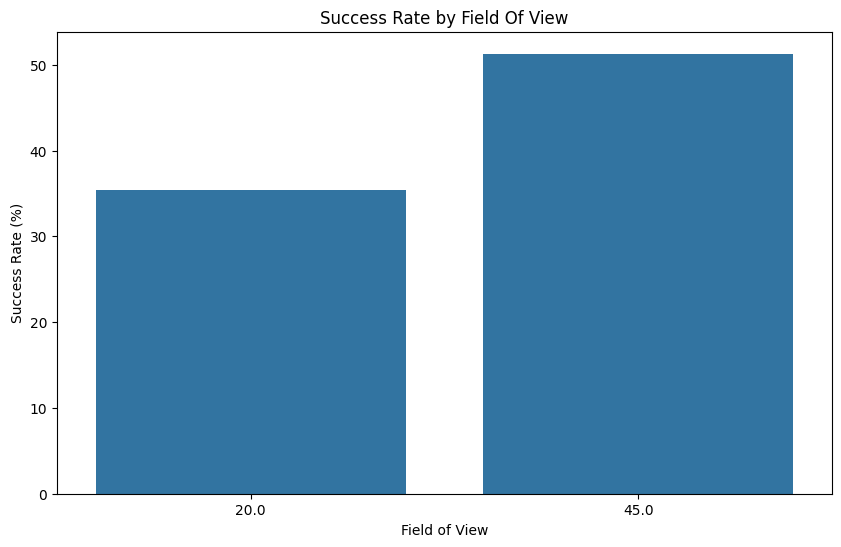

T-statistic: -1.4904918396877573
P-value: 0.13979663260734188
Cohen's d: -0.3213189260615526
corresponding_fieldOfView
20.0    32.352941
45.0    50.000000
Name: corresponding_answer_correct, dtype: float64


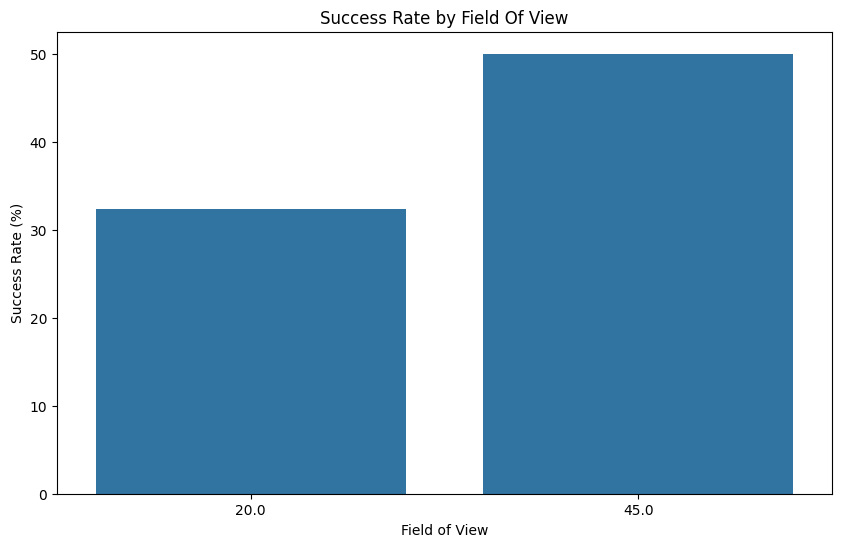

T-statistic: -1.519548544067539
P-value: 0.13312862073424156
Cohen's d: -0.35871502698971963
corresponding_fieldOfView
0.0     100.000000
20.0     44.000000
45.0     33.333333
Name: corresponding_answer_correct, dtype: float64


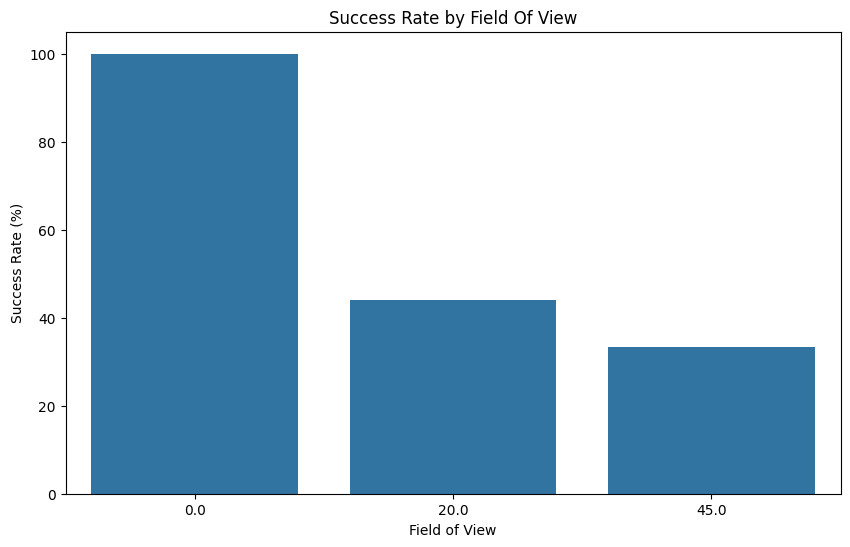

T-statistic: 0.7792865001991968
P-value: 0.4394839793291442
Cohen's d: 0.2162952281743501


FileNotFoundError: [Errno 2] No such file or directory: 'F:\\PM_Polyretina\\Data\\Post_2023_Control_Center_Data\\P8-PostEEG_TrackerData.csv'

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def process_csv_pair(csv1, csv2):

    # Load the first CSV
    df = pd.read_csv(csv1, sep=';', low_memory=False)
    

    df['date'] = df['date'].astype(str)  # Ensure all entries are strings
    df['date'] = df['date'].str.pad(width=20, side='right', fillchar='0') # adding zero at end if missing digits
    df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')
    df = df.iloc[:-1]

    df_start_trial = df[df['tagLabel'] == 'Start trial'].copy()

    # Calculate the date difference for each group and only keep the first row for each group
    df_start_trial['date_interval'] = df_start_trial.groupby('trialid')['date'].transform(lambda x: pd.Interval(x.min(), x.max()))
    df_start_trial = df_start_trial.drop_duplicates(subset='trialid', keep='first')







    # Load the second CSV
    df_other = pd.read_csv(csv2, sep=';', low_memory=False)

    df_other['date_end'] = df_other['date_end'].astype(str)  # Ensure all entries are strings
    df_other['date_end'] = df_other['date_end'].str.pad(width=20, side='right', fillchar='0') # adding a zero at the end if only one digit : useful ?
    df_other['date_end'] = pd.to_datetime(df_other['date_end'], errors='coerce', dayfirst=True, format='%d.%m.%y %H:%M:%S:%f')
        
    # Initialize a list to hold the results
    is_in_interval = []
    corresponding_fieldOfView = []
    corresponding_answer_correct = []

    # Check whether each date in df_other is in any of the intervals in df_start_trial
    for idx, date in df_other['date_end'].items():
        is_in_any_interval = False
        for _, interval_row in df_start_trial.iterrows():
            if date in interval_row['date_interval']:
                is_in_any_interval = True
                corresponding_fieldOfView.append(interval_row['fieldOfView'])
                corresponding_answer_correct.append(df_other.loc[idx, 'answer_correct'])
                break
        if not is_in_any_interval:
            corresponding_fieldOfView.append(None)
            corresponding_answer_correct.append(None)
        is_in_interval.append(is_in_any_interval)

    # Add the results to df_other
    df_other['is_in_interval'] = is_in_interval
    df_other['corresponding_fieldOfView'] = corresponding_fieldOfView
    df_other['corresponding_answer_correct'] = corresponding_answer_correct


    # Visualization and statistical tests
    
    # Convert boolean to integer
    df_other['corresponding_answer_correct'] = df_other['corresponding_answer_correct'].map({True: 1, False: 0})

    # Calculate success rate and convert to percentage
    success_rate = df_other.groupby('corresponding_fieldOfView')['corresponding_answer_correct'].mean() * 100
    print(success_rate)

    # Convert to DataFrame
    success_rate_df = success_rate.reset_index()
    success_rate_df.columns = ['Field of View', 'Success Rate (%)']

    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x='Field of View', y='Success Rate (%)', data=success_rate_df)
    plt.title('Success Rate by Field Of View')
    plt.xlabel('Field of View')
    plt.ylabel('Success Rate (%)')
    plt.show()

    # Split the success rate data into two groups
    group1 = df_other[df_other['corresponding_fieldOfView'] == 20]['corresponding_answer_correct']
    group2 = df_other[df_other['corresponding_fieldOfView'] == 45]['corresponding_answer_correct']

    # Perform the t-test
    t_stat, p_val = stats.ttest_ind(group1, group2)
    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_val}')

    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    d = (mean1 - mean2) / pooled_std # Cohen's d
    print(f"Cohen's d: {d}")


# List of CSV pairs
prefixes = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']
path1 = 'F:\PM_Polyretina\Data\Post_2023_Control_Center_Data'
path2 = 'F:\PM_Polyretina\Data\Post_2023_Button_tags'

# Loop over the CSV pairs and process them
for prefix in prefixes:
    csv1 = f"{path1}\\{prefix}-PostEEG_TrackerData.csv"
    csv2 = f"{path2}\\post_eeg_button_tags_{prefix}.csv"
    result_df = process_csv_pair(csv1, csv2)
